In [1]:
# author: René Kopeinig
# script: Time Series Forecast
# description: Time Series Forecast on Proba-V NDVI, Landsat 8 NDVI and CHIRPS precipitation data
#              Note: Please make sure you have all dependencies in Python installed and you are signed up for Google Earth Engine.

In [1]:
# Add IPython-specific directive to display plots directly below the notebook cell
%matplotlib inline

In [11]:
# Import Dependencies
import ee, datetime
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.formula.api as smf
from fbprophet import Prophet
from IPython.display import Image
from matplotlib import dates
from pylab import *
from numpy import fft
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import MonthEnd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [44]:
# Initialize
ee.Initialize()

# Set start and end date
startTime = datetime.datetime(2013, 2, 3)
endTime = datetime.datetime(2019, 5, 25)

# Create image collection
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT').filterDate(startTime, endTime)
precipitation = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD').filterDate(startTime, endTime)
probav = ee.ImageCollection('VITO/PROBAV/C1/S1_TOC_100M').filterDate(startTime, endTime)
point = {'type':'Point', 'coordinates':[-99.545934,20.572173]};

In [45]:
#Retrieve information over image collection
info_l8 = l8.getRegion(point,500).getInfo()
info_chirps = precipitation.getRegion(point, 500).getInfo()
info_probav = probav.getRegion(point, 500).getInfo()

In [56]:
# Reshape Landsat 8
header = info_l8[0]
data = array(info_l8[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
band_list = ['B5',u'B4']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# Reshape NDVI array into Pandas Dataframe
df = pd.DataFrame(data=ndvi*-1, index=time, columns=['ndvi'])
df_red=pd.DataFrame(data=red, index=time, columns=['red'])
l8_time_series = df.dropna()

# Resampling
monthly_landsat = l8_time_series.resample('M', how='mean')

In [57]:
# Reshape Chirps precipitation data 
header = info_chirps[0]
data = array(info_chirps[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

band_list=['precipitation']
iBands = [header.index(b) for b in band_list]
chirps = data[0:,iBands].astype(np.float)

df = pd.DataFrame(data=chirps, index=time, columns=['precipitation'])
chirps_time_series = df.dropna()

# Resampling
monthly_chirps = chirps_time_series.resample('M', how='mean')

In [58]:
# Reshape Proba-V image collection 
header = info_probav[0]
data = array(info_probav[1:])
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

band_list=['NDVI']
iBands = [header.index(b) for b in band_list]
ndvi = data[0:,iBands].astype(np.float)

df = pd.DataFrame(data=ndvi, index=time, columns=['ndvi'])
probav_time_series = df.dropna()

# Resampling
monthly_probav = probav_time_series.resample('M', how='mean')

In [59]:
monthly = pd.DataFrame({'landsat': monthly_landsat['ndvi'],
                        'chirps': monthly_chirps['precipitation'],
                        'probav':monthly_probav['ndvi']},index = monthly_chirps.index)

In [60]:
# Reshape data for Forecast
monthly['y'] = monthly['probav']
monthly['ds'] = monthly.index
period=len(monthly_probav['ndvi']['2017-01-01':])
monthly=monthly['2014-01-01':'2016-12-31']

# Forecasting Proba-V data using Chirps and Landsat as regressors 
m = Prophet(yearly_seasonality=15,seasonality_mode='additive')
m.add_regressor('chirps')
m.add_regressor('landsat')
m.fit(monthly)

# Create future dataframe
future = m.make_future_dataframe(periods=period, freq='M', include_history=False)
future['chirps']=0
future['landsat']=0

# Forecast
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Proba-V Monthly Forecast')

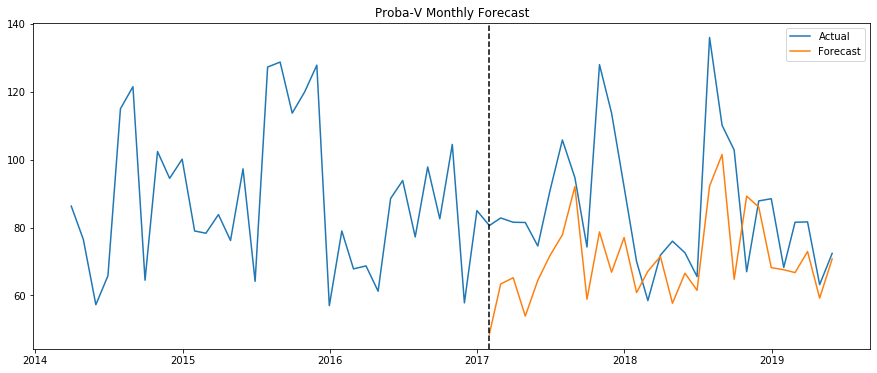

In [61]:
# Plot results
plt.plot(monthly_probav.index,monthly_probav.ndvi)
plt.plot(forecast.ds,forecast.yhat)
plt.axvline(x=forecast.ds.values[0], color='k', linestyle='--')
plt.legend(['Actual', 'Forecast'])
plt.title('Proba-V Monthly Forecast')